In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Model imports
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import GridSearchCV

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
# Tools for developing code
%load_ext autoreload 
%autoreload 2

# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lib.model import kfold, f1_scorer
from lib.model import load_and_process_training_data
from lib.model import transformer_pipeline, pipeline_rf, pipeline_svc
from lib.visualization import compare_algorithm_cv_scores, plot_algorithm_cv_scores, report_cv_scores
from lib.visualization import plot_learning_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
X_train, y_train = load_and_process_training_data()

## Quick comparison of (untuned) algorithms

In [6]:
algs = [RandomForestClassifier, ExtraTreesClassifier,
        GradientBoostingClassifier, LGBMClassifier, XGBClassifier,
        LinearSVC, SVC, GaussianNB, MLPClassifier, LogisticRegressionCV, RidgeClassifierCV, 
       LinearDiscriminantAnalysis, KNeighborsClassifier]

In [7]:
%%time
model_results = compare_algorithm_cv_scores(transformer_pipeline, algs, X_train, y_train, kfold, f1_scorer)

RandomForestClassifier CV Score: 0.36054 with std: 0.01406
ExtraTreesClassifier CV Score: 0.3509 with std: 0.02503
GradientBoostingClassifier CV Score: 0.33435 with std: 0.01043
LGBMClassifier CV Score: 0.33814 with std: 0.02415
XGBClassifier CV Score: 0.32746 with std: 0.02494
LinearSVC CV Score: 0.3241 with std: 0.01919
SVC CV Score: 0.32396 with std: 0.01596
GaussianNB CV Score: 0.3651 with std: 0.03135
MLPClassifier CV Score: 0.33821 with std: 0.03766
LogisticRegressionCV CV Score: 0.27631 with std: 0.03393
RidgeClassifierCV CV Score: 0.29712 with std: 0.01554
LinearDiscriminantAnalysis CV Score: 0.33798 with std: 0.02334
KNeighborsClassifier CV Score: 0.32165 with std: 0.01998
Wall time: 4min 35s


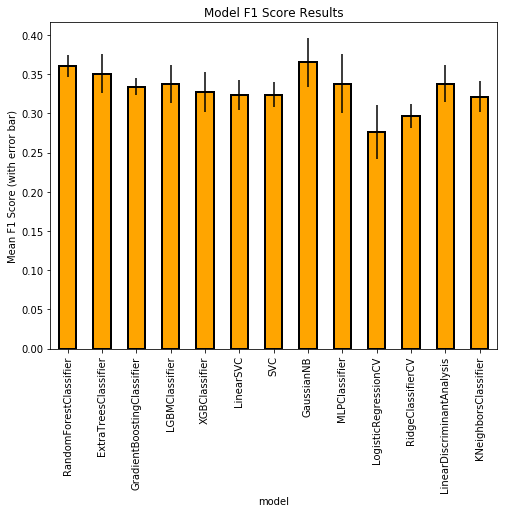

In [8]:
plot_algorithm_cv_scores(model_results)

## To include feature engineering in pipeline or not? 
There is a `FeatureUnion` with all feature engineering steps, but it's slower to include these in the pipeline during hyperparameter tuning. Let's see by how much.
First we tune Random Forest depth using a pipeline including transformers. 
Second we tune the depth using data already `fit_transform`'ed by the transformer pipeline. 

In [9]:
DEPTHS = [20, 30, 40]
param_grid_rf = dict(random_forest__max_depth=DEPTHS,)

In [21]:
%%time

grid = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

report_cv_scores(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.369 (std: 0.030)
Parameters: {'features__extract_assets__level': 'low', 'features__extract_demog__level': 'low', 'features__extract_educ__level': 'low', 'features__extract_housec__level': 'low', 'features__extract_houseq__level': 'low', 'features__extract_rent__level': 'low', 'random_forest__max_depth': 40}

Model with rank: 2
Mean validation score: 0.361 (std: 0.020)
Parameters: {'features__extract_assets__level': 'low', 'features__extract_demog__level': 'low', 'features__extract_educ__level': 'low', 'features__extract_housec__level': 'low', 'features__extract_houseq__level': 'low', 'features__extract_rent__level': 'low', 'random_forest__max_depth': 20}

Model with rank: 3
Mean validation score: 0.358 (std: 0.023)
Parameters: {'features__extract_assets__level': 'low', 'features__extract_demog__level': 'low', 'features__extract_educ__level': 'low', 'features__extract_housec__level': 'low', 'features__extract_houseq__level': 'low', 'features__

In [10]:
X_processed = transformer_pipeline.fit_transform(X_train)
rf = RandomForestClassifier(random_state=1)
param_grid_rf2 = dict(max_depth=DEPTHS)

In [19]:
%%time

grid = GridSearchCV(rf, param_grid=param_grid_rf2, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_processed, y_train)

report_cv_scores(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.349 (std: 0.019)
Parameters: {'max_depth': 40}

Model with rank: 2
Mean validation score: 0.349 (std: 0.019)
Parameters: {'max_depth': 30}

Model with rank: 3
Mean validation score: 0.349 (std: 0.018)
Parameters: {'max_depth': 20}

Wall time: 6.32 s


#### Okay, so we have a small improvement in model performance, but the model tuning takes ~10X as long since the feature engineering must be done in each cross validation fold in each parameter space
#### So for now, let's use a random forest with max_depth=20 to do some coarse tuning of feature engineering

In [7]:
%%time

LEVELS = ['low'] # , 'medium', 'high']
param_grid_features = dict(features__extract_educ__level=LEVELS,
                 features__extract_rent__level=LEVELS,
                 features__extract_demog__level=LEVELS,
                 features__extract_houseq__level=LEVELS,
                 features__extract_housec__level=LEVELS,
                 features__extract_assets__level=LEVELS,
                 random_forest__max_depth = [40]
                 )

grid = GridSearchCV(pipeline_rf, param_grid=param_grid_features, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

report_cv_scores(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.369 (std: 0.030)
Parameters: {'features__extract_assets__level': 'low', 'features__extract_demog__level': 'low', 'features__extract_educ__level': 'low', 'features__extract_housec__level': 'low', 'features__extract_houseq__level': 'low', 'features__extract_rent__level': 'low', 'random_forest__max_depth': 40}

Wall time: 23.8 s


## Tune and compare SCV and RandomForest

In [11]:
X_processed = transformer_pipeline.fit_transform(X_train)

In [13]:
%%time
param_grid = dict(max_depth = [20,30,40])
grid = GridSearchCV(RandomForestClassifier(random_state=1), param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_processed, y_train)

report_cv_scores(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.349 (std: 0.019)
Parameters: {'max_depth': 40}

Model with rank: 2
Mean validation score: 0.349 (std: 0.019)
Parameters: {'max_depth': 30}

Model with rank: 3
Mean validation score: 0.349 (std: 0.018)
Parameters: {'max_depth': 20}

Wall time: 4.3 s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

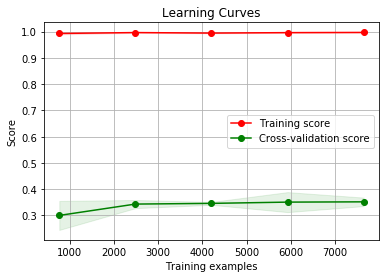

In [15]:
model = grid.best_estimator_
model.fit(X_processed, y_train)
plot_learning_curve(model, 'Learning Curves', X_processed, y_train, cv=kfold, scoring=f1_scorer)

In [16]:
%%time
param_grid = dict(gamma=[0.01, 0.1,1,10],
                  C=[0.001,0.01,0.1,1,10,100,1000])
grid = GridSearchCV(SVC(random_state=1), param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_processed, y_train)

report_cv_scores(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.332 (std: 0.023)
Parameters: {'C': 10, 'gamma': 0.01}

Model with rank: 2
Mean validation score: 0.326 (std: 0.026)
Parameters: {'C': 100, 'gamma': 0.01}

Model with rank: 3
Mean validation score: 0.323 (std: 0.027)
Parameters: {'C': 1000, 'gamma': 0.01}

Wall time: 19min 13s


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\runpy.py in _run_code(code=<code object <module> at 0x000001FFF47CDC00, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\users\zrankin\appdata\local\continuum\minicon...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\users\zrankin\appdata\local\continuum\minicon...vs\kaggle\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\users\\z...le\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001FFF47CDC00, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\users\zrankin\appdata\local\continuum\minicon...ges\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\users\zrankin\appdata\local\continuum\minicon...vs\kaggle\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...ggle\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\users\\z...le\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    492         if self.poller is not None:
    493             self.poller.start()
    494         self.kernel.start()
    495         self.io_loop = ioloop.IOLoop.current()
    496         try:
--> 497             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    498         except KeyboardInterrupt:
    499             pass
    500 
    501 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1429                         logger.warning('Executing %s took %.3f seconds',
   1430                                        _format_handle(handle), dt)
   1431                 finally:
   1432                     self._current_handle = None
   1433             else:
-> 1434                 handle._run()
        handle._run = <bound method Handle._run of <Handle IOLoop._run_callback(functools.par...01FF87C866A8>))>>
   1435         handle = None  # Needed to break cycles when an exception occurs.
   1436 
   1437     def _set_coroutine_wrapper(self, enabled):
   1438         try:

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\asyncio\events.py in _run(self=<Handle IOLoop._run_callback(functools.par...01FF87C866A8>))>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method IOLoop._run_callback of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (functools.partial(<function wrap.<locals>.null_wrapper at 0x000001FF87C866A8>),)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\ioloop.py in _run_callback(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, callback=functools.partial(<function wrap.<locals>.null_wrapper at 0x000001FF87C866A8>))
    753         """Runs a callback with error handling.
    754 
    755         For use in subclasses.
    756         """
    757         try:
--> 758             ret = callback()
        ret = undefined
        callback = functools.partial(<function wrap.<locals>.null_wrapper at 0x000001FF87C866A8>)
    759             if ret is not None:
    760                 from tornado import gen
    761                 # Functions that return Futures typically swallow all
    762                 # exceptions and store them in the Future.  If a Future

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ()
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\zmq\eventloop\zmqstream.py in <lambda>()
    531             return
    532 
    533         if state & self.socket.events:
    534             # events still exist that haven't been processed
    535             # explicitly schedule handling to avoid missing events due to edge-triggered FDs
--> 536             self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
    537 
    538     def _init_io_state(self):
    539         """initialize the ioloop event handler"""
    540         with stack_context.NullContext():

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=0)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 27, 13, 15, 34, 995165, tzinfo=tzutc()), 'msg_id': '879ffb0da42646a4a99f68c1b43d5205', 'msg_type': 'execute_request', 'session': '7b364aaa21f847b886d86b7e62f01249', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '879ffb0da42646a4a99f68c1b43d5205', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'7b364aaa21f847b886d86b7e62f01249']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 27, 13, 15, 34, 995165, tzinfo=tzutc()), 'msg_id': '879ffb0da42646a4a99f68c1b43d5205', 'msg_type': 'execute_request', 'session': '7b364aaa21f847b886d86b7e62f01249', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '879ffb0da42646a4a99f68c1b43d5205', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'7b364aaa21f847b886d86b7e62f01249'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 9, 27, 13, 15, 34, 995165, tzinfo=tzutc()), 'msg_id': '879ffb0da42646a4a99f68c1b43d5205', 'msg_type': 'execute_request', 'session': '7b364aaa21f847b886d86b7e62f01249', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '879ffb0da42646a4a99f68c1b43d5205', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>, <_ast.Expr object>], cell_name='<ipython-input-17-faf0ae23d89b>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1ff87deee48, executio...rue silent=False shell_futures=True> result=None>)
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])
   2906                 code = compiler(mod, cell_name, "single")
-> 2907                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001FF8881FF60, file "<ipython-input-17-faf0ae23d89b>", line 3>
        result = <ExecutionResult object at 1ff87deee48, executio...rue silent=False shell_futures=True> result=None>
   2908                     return True
   2909 
   2910             # Flush softspace
   2911             if softspace(sys.stdout, 0):

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001FF8881FF60, file "<ipython-input-17-faf0ae23d89b>", line 3>, result=<ExecutionResult object at 1ff87deee48, executio...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001FF8881FF60, file "<ipython-input-17-faf0ae23d89b>", line 3>
        self.user_global_ns = {'DEPTHS': [20, 30, 40], 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import os\nimport sys\nimport numpy as np\nimport p..._ipython().run_line_magic('matplotlib', 'inline')", '# Model imports\nfrom sklearn.svm import LinearSV...\nfrom sklearn.model_selection import GridSearchCV', '# Tools for developing code\nget_ipython().run_li...port_cv_scores\n# import lib.preprocessing as prep', 'X_train, y_train = load_and_process_training_data()', 'get_ipython().run_cell_magic(\'time\', \'\', "\\nLEVE... y_train)\\n\\nreport_cv_scores(grid.cv_results_)")', 'get_ipython().run_cell_magic(\'time\', \'\', "\\nLEVE... y_train)\\n\\nreport_cv_scores(grid.cv_results_)")', 'get_ipython().run_cell_magic(\'time\', \'\', "\\nLEVE... y_train)\\n\\nreport_cv_scores(grid.cv_results_)")', 'X_processed = transformer_pipeline.fit_transform..._state=1)\nparam_grid_rf2 = dict(max_depth=DEPTHS)', 'DEPTHS = [20, 30, 40]\nparam_grid_rf = dict(random_forest__max_depth=DEPTHS,)', 'X_processed = transformer_pipeline.fit_transform..._state=1)\nparam_grid_rf2 = dict(max_depth=DEPTHS)', 'X_processed = transformer_pipeline.fit_transform(X_train)', '# Tools for developing code\nget_ipython().run_li...from lib.visualization import plot_learning_curve', r"get_ipython().run_cell_magic('time', '', 'param_... y_train)\n\nreport_cv_scores(grid.cv_results_)')", "model = grid.best_estimator_\nmodel.fit(X_train, ...', X_train, y_train, cv=kfold, scoring=f1_scorer)", 'model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)', r"get_ipython().run_cell_magic('time', '', 'param_... y_train)\n\nreport_cv_scores(grid.cv_results_)')", 'model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)'], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LEVELS': ['low'], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'LinearDiscriminantAnalysis': <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>, ...}
        self.user_ns = {'DEPTHS': [20, 30, 40], 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import os\nimport sys\nimport numpy as np\nimport p..._ipython().run_line_magic('matplotlib', 'inline')", '# Model imports\nfrom sklearn.svm import LinearSV...\nfrom sklearn.model_selection import GridSearchCV', '# Tools for developing code\nget_ipython().run_li...port_cv_scores\n# import lib.preprocessing as prep', 'X_train, y_train = load_and_process_training_data()', 'get_ipython().run_cell_magic(\'time\', \'\', "\\nLEVE... y_train)\\n\\nreport_cv_scores(grid.cv_results_)")', 'get_ipython().run_cell_magic(\'time\', \'\', "\\nLEVE... y_train)\\n\\nreport_cv_scores(grid.cv_results_)")', 'get_ipython().run_cell_magic(\'time\', \'\', "\\nLEVE... y_train)\\n\\nreport_cv_scores(grid.cv_results_)")', 'X_processed = transformer_pipeline.fit_transform..._state=1)\nparam_grid_rf2 = dict(max_depth=DEPTHS)', 'DEPTHS = [20, 30, 40]\nparam_grid_rf = dict(random_forest__max_depth=DEPTHS,)', 'X_processed = transformer_pipeline.fit_transform..._state=1)\nparam_grid_rf2 = dict(max_depth=DEPTHS)', 'X_processed = transformer_pipeline.fit_transform(X_train)', '# Tools for developing code\nget_ipython().run_li...from lib.visualization import plot_learning_curve', r"get_ipython().run_cell_magic('time', '', 'param_... y_train)\n\nreport_cv_scores(grid.cv_results_)')", "model = grid.best_estimator_\nmodel.fit(X_train, ...', X_train, y_train, cv=kfold, scoring=f1_scorer)", 'model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)', r"get_ipython().run_cell_magic('time', '', 'param_... y_train)\n\nreport_cv_scores(grid.cv_results_)')", 'model = grid.best_estimator_\nmodel.fit(X_process..._processed, y_train, cv=kfold, scoring=f1_scorer)'], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LEVELS': ['low'], 'LGBMClassifier': <class 'lightgbm.sklearn.LGBMClassifier'>, 'LinearDiscriminantAnalysis': <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>, ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
C:\Users\zrankin\Documents\github\poverty_prediction\notebooks\<ipython-input-17-faf0ae23d89b> in <module>()
      1 model = grid.best_estimator_
      2 model.fit(X_processed, y_train)
----> 3 plot_learning_curve(model, 'Learning Curves', X_processed, y_train, cv=kfold, scoring=f1_scorer)

...........................................................................
C:\Users\zrankin\Documents\github\poverty_prediction\lib\visualization.py in plot_learning_curve(estimator=SVC(C=10, cache_size=200, class_weight=None, coe...te=1, shrinking=True,
  tol=0.001, verbose=False), title='Learning Curves', X=array([[ 1.27922814,  0.90070671,  3.57226664, .... -0.06234224,
        -0.33725311,  1.58543462]]), y=0       4
1       4
2       4
3       4
4       ...556    2
Name: Target, Length: 9557, dtype: int64, ylim=None, cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False), scoring=make_scorer(f1_score, average=macro), n_jobs=-1, train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]))
     33     if ylim is not None:
     34         plt.ylim(*ylim)
     35     plt.xlabel("Training examples")
     36     plt.ylabel("Score")
     37     train_sizes, train_scores, test_scores = learning_curve(
---> 38         estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
        estimator = SVC(C=10, cache_size=200, class_weight=None, coe...te=1, shrinking=True,
  tol=0.001, verbose=False)
        X = array([[ 1.27922814,  0.90070671,  3.57226664, .... -0.06234224,
        -0.33725311,  1.58543462]])
        y = 0       4
1       4
2       4
3       4
4       ...556    2
Name: Target, Length: 9557, dtype: int64
        cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=False)
        scoring = make_scorer(f1_score, average=macro)
        n_jobs = -1
        train_sizes = array([0.1  , 0.325, 0.55 , 0.775, 1.   ])
     39     train_scores_mean = np.mean(train_scores, axis=1)
     40     train_scores_std = np.std(train_scores, axis=1)
     41     test_scores_mean = np.mean(test_scores, axis=1)
     42     test_scores_std = np.std(test_scores, axis=1)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_validation.py in learning_curve(estimator=SVC(C=10, cache_size=200, class_weight=None, coe...te=1, shrinking=True,
  tol=0.001, verbose=False), X=array([[ 1.27922814,  0.90070671,  3.57226664, .... -0.06234224,
        -0.33725311,  1.58543462]]), y=0       4
1       4
2       4
3       4
4       ...556    2
Name: Target, Length: 9557, dtype: int64, groups=None, train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False), scoring=make_scorer(f1_score, average=macro), exploit_incremental_learning=False, n_jobs=-1, pre_dispatch='all', verbose=0, shuffle=False, random_state=None)
   1123                 train_test_proportions.append((train[:n_train_samples], test))
   1124 
   1125         out = parallel(delayed(_fit_and_score)(
   1126             clone(estimator), X, y, scorer, train, test,
   1127             verbose, parameters=None, fit_params=None, return_train_score=True)
-> 1128             for train, test in train_test_proportions)
        train = array([   0,    1,    2, ..., 8142, 8143, 8159])
        test = array([7206, 7207, 7208, ..., 9554, 9555, 9556])
        train_test_proportions = [(array([1575, 1576, 1577, 1578, 1579, 1580, 1581,...2588, 2589,
       2590, 2591, 2592, 2593, 2594]), array([   0,    1,    2, ..., 3102, 3103, 3104])), (array([1575, 1576, 1577, ..., 4394, 4395, 4396]), array([   0,    1,    2, ..., 3102, 3103, 3104])), (array([1575, 1576, 1577, ..., 6114, 6115, 6116]), array([   0,    1,    2, ..., 3102, 3103, 3104])), (array([1575, 1576, 1577, ..., 7834, 7835, 7836]), array([   0,    1,    2, ..., 3102, 3103, 3104])), (array([1575, 1576, 1577, ..., 9554, 9555, 9556]), array([   0,    1,    2, ..., 3102, 3103, 3104])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ...54, 755, 756, 757, 758, 759, 760, 761, 762, 763]), array([1575, 1576, 1577, ..., 5438, 5439, 5440])), (array([   0,    1,    2, ..., 4203, 4204, 4205]), array([1575, 1576, 1577, ..., 5438, 5439, 5440])), (array([   0,    1,    2, ..., 6113, 6114, 6115]), array([1575, 1576, 1577, ..., 5438, 5439, 5440])), (array([   0,    1,    2, ..., 7833, 7834, 7835]), array([1575, 1576, 1577, ..., 5438, 5439, 5440])), (array([   0,    1,    2, ..., 9553, 9554, 9555]), array([1575, 1576, 1577, ..., 5438, 5439, 5440])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ...54, 755, 756, 757, 758, 759, 760, 761, 762, 763]), array([3271, 3272, 3273, ..., 6747, 6748, 6749])), (array([   0,    1,    2, ..., 2481, 2482, 2483]), array([3271, 3272, 3273, ..., 6747, 6748, 6749])), (array([   0,    1,    2, ..., 5687, 5688, 5689]), array([3271, 3272, 3273, ..., 6747, 6748, 6749])), (array([   0,    1,    2, ..., 7832, 7833, 7834]), array([3271, 3272, 3273, ..., 6747, 6748, 6749])), (array([   0,    1,    2, ..., 9552, 9553, 9554]), array([3271, 3272, 3273, ..., 6747, 6748, 6749])), (array([  0,   1,   2,   3,   4,   5,   6,   7,  ...54, 755, 756, 757, 758, 759, 760, 761, 762, 763]), array([5062, 5063, 5064, ..., 8142, 8143, 8159])), (array([   0,    1,    2, ..., 2481, 2482, 2483]), array([5062, 5063, 5064, ..., 8142, 8143, 8159])), (array([   0,    1,    2, ..., 4201, 4202, 4203]), array([5062, 5063, 5064, ..., 8142, 8143, 8159])), (array([   0,    1,    2, ..., 7548, 7549, 7550]), array([5062, 5063, 5064, ..., 8142, 8143, 8159])), (array([   0,    1,    2, ..., 9552, 9553, 9554]), array([5062, 5063, 5064, ..., 8142, 8143, 8159])), ...]
   1129         out = np.array(out)
   1130         n_cv_folds = out.shape[0] // n_unique_ticks
   1131         out = out.reshape(n_cv_folds, n_unique_ticks, 2)
   1132 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object learning_curve.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Sep 27 08:34:59 2018
PID: 11336Python 3.6.6: c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\python.exe
...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (SVC(C=10, cache_size=200, class_weight=None, coe...te=1, shrinking=True,
  tol=0.001, verbose=False), memmap([[ 1.27922814,  0.90070671,  3.57226664, ...-0.06234224,
         -0.33725311,  1.58543462]]), 0       4
1       4
2       4
3       4
4       ...556    2
Name: Target, Length: 9557, dtype: int64, make_scorer(f1_score, average=macro), array([1575, 1576, 1577, 1578, 1579, 1580, 1581,...2588, 2589,
       2590, 2591, 2592, 2593, 2594]), array([   0,    1,    2, ..., 3102, 3103, 3104]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (SVC(C=10, cache_size=200, class_weight=None, coe...te=1, shrinking=True,
  tol=0.001, verbose=False), memmap([[ 1.27922814,  0.90070671,  3.57226664, ...-0.06234224,
         -0.33725311,  1.58543462]]), 0       4
1       4
2       4
3       4
4       ...556    2
Name: Target, Length: 9557, dtype: int64, make_scorer(f1_score, average=macro), array([1575, 1576, 1577, 1578, 1579, 1580, 1581,...2588, 2589,
       2590, 2591, 2592, 2593, 2594]), array([   0,    1,    2, ..., 3102, 3103, 3104]), 0)
        kwargs = {'fit_params': None, 'parameters': None, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=SVC(C=10, cache_size=200, class_weight=None, coe...te=1, shrinking=True,
  tol=0.001, verbose=False), X=memmap([[ 1.27922814,  0.90070671,  3.57226664, ...-0.06234224,
         -0.33725311,  1.58543462]]), y=0       4
1       4
2       4
3       4
4       ...556    2
Name: Target, Length: 9557, dtype: int64, scorer=make_scorer(f1_score, average=macro), train=array([1575, 1576, 1577, 1578, 1579, 1580, 1581,...2588, 2589,
       2590, 2591, 2592, 2593, 2594]), test=array([   0,    1,    2, ..., 3102, 3103, 3104]), verbose=0, parameters=None, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseLibSVM.fit of SVC(C=10, cache_...e=1, shrinking=True,
  tol=0.001, verbose=False)>
        X_train = memmap([[-4.79087823e-01, -3.27085905e-01, -5.97...23422379e-02, -3.37253106e-01, -6.30741871e-01]])
        y_train = 1575    4
1576    4
1577    4
1578    4
1579    ...2594    4
Name: Target, Length: 764, dtype: int64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\svm\base.py in fit(self=SVC(C=10, cache_size=200, class_weight=None, coe...te=1, shrinking=True,
  tol=0.001, verbose=False), X=array([[-4.79087823e-01, -3.27085905e-01, -5.971...23422379e-02, -3.37253106e-01, -6.30741871e-01]]), y=array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,...4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64), sample_weight=None)
    145         if sparse and self.kernel == "precomputed":
    146             raise TypeError("Sparse precomputed kernels are not supported.")
    147         self._sparse = sparse and not callable(self.kernel)
    148 
    149         X, y = check_X_y(X, y, dtype=np.float64, order='C', accept_sparse='csr')
--> 150         y = self._validate_targets(y)
        y = array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,...4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)
        self._validate_targets = <bound method BaseSVC._validate_targets of SVC(C...e=1, shrinking=True,
  tol=0.001, verbose=False)>
    151 
    152         sample_weight = np.asarray([]
    153                                    if sample_weight is None
    154                                    else sample_weight, dtype=np.float64)

...........................................................................
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\svm\base.py in _validate_targets(self=SVC(C=10, cache_size=200, class_weight=None, coe...te=1, shrinking=True,
  tol=0.001, verbose=False), y=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))
    501         cls, y = np.unique(y_, return_inverse=True)
    502         self.class_weight_ = compute_class_weight(self.class_weight, cls, y_)
    503         if len(cls) < 2:
    504             raise ValueError(
    505                 "The number of classes has to be greater than one; got %d"
--> 506                 % len(cls))
        cls = array([4], dtype=int64)
    507 
    508         self.classes_ = cls
    509 
    510         return np.asarray(y, dtype=np.float64, order='C')

ValueError: The number of classes has to be greater than one; got 1
___________________________________________________________________________

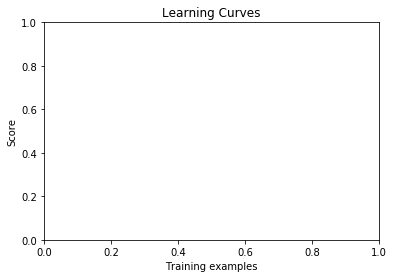

In [17]:
model = grid.best_estimator_
model.fit(X_processed, y_train)
plot_learning_curve(model, 'Learning Curves', X_processed, y_train, cv=kfold, scoring=f1_scorer)

In [9]:
LEVELS = ['low']
DEPTHS = [20, 30, 40]
param_grid_rf = dict(features__extract_educ__level=LEVELS,
                 features__extract_rent__level=LEVELS,
                 features__extract_demog__level=LEVELS,
                 features__extract_houseq__level=LEVELS,
                 features__extract_housec__level=LEVELS,
                 features__extract_assets__level=LEVELS,
                 random_forest__max_depth=DEPTHS,
                 )

param_grid_svc = dict(features__extract_educ__level=LEVELS,
                 features__extract_rent__level=LEVELS,
                 features__extract_demog__level=LEVELS,
                 features__extract_houseq__level=LEVELS,
                 features__extract_housec__level=LEVELS,
                 features__extract_assets__level=LEVELS,
                 svc__gamma=[0.01, 0.1,1,10],
                 svc__C=[0.001,0.01,0.1,1,10,100,1000]
                 )

In [10]:
test = transformer_pipeline.fit_transform(X_train)
test.shape

(9557, 68)

In [11]:
pipeline_rf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('extract_rent', FeatureEngineer(drop_correlated_features=False,
        func=<function feature_engineer_rent at 0x0000020B0B8A56A8>,
        level='low')), ('extract_educ', FeatureEngineer(drop_correlated_features=False,
        fu...estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

In [12]:
pred = pipeline_rf.predict(X_train)

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipeline_rf, X_train, y_train, scoring=f1_scorer, cv=kfold)

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['adult_percent'] = df['hogar_adul'] / df['hogar_total']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['r4h1_percent_in_male'] = df['r4h1'] / df['r4h3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['cooking_rank'] = 0 * df['energcocinar4'] + df['energcocinar3'] + 2 * df['energcocinar1'] + 3 * df['energcocinar2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['trash_rank'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:349: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:277: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['male_per_room'] = df['r4h3'] / df['rooms']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['female_per_room'] = df['r4m3'] / df['rooms']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rent_by_living'] = df['v2a1'] / df['tamviv']  # rent by number of persons living in the household
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rent_by_minor'] = df['v2a1'] / df['hogar_nin']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy o

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['r4m1_percent_in_total'] = df['r4m1'] / df['hhsize']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['r4t1_percent_in_total'] = df['r4t1'] / df['hhsize']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['roof_quality'] = 0 * df['etecho1'] + 1 * df['etecho2'] + 2 * df['etecho3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['floor_quality'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['female_per_bedroom'] = df['r4m3'] / df['bedrooms']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['bedrooms_per_person_household'] = df['hhsize'] / df['bedrooms']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['higher_education'] = df['instlevel8'] + df['instlevel9']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['roof_rank'] = 0 * df['techocane'] + df['techoentrepiso'] + 2 * df['techozinc'] + 3 * df['techootro']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['water_rank'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['utility_rank_sum'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['utility_rank_sum'] = df['water_rank'] + df['electricity_rank'] + df['toilet_rank'] + df['cooking_rank'] + df['trash_rank']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:263: SettingWithCopyWarning: 
A value is trying to be set on a 

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['tablet_per_person_household'] = df['v18q1'] / df['hhsize']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phone_per_person_household'] = df['qmobilephone'] / df['hhsize']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:394: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['age_7_17'] = np.where((df['age'] >= 7) & (df['age'] <= 17), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['adult'] = np.where(df['age'] > 18, 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['cooking_rank'] = 0 * df['energcocinar4'] + df['energcocinar3'] + 2 * df['energcocinar1'] + 3 * df['energcocinar2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['trash_rank'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:349: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['bedroom_per_room'] = df['bedrooms'] / df['rooms']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elder_per_room'] = df['hogar_mayor'] / df['rooms']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rent_by_living'] = df['v2a1'] / df['tamviv']  # rent by number of persons living in the household
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rent_by_minor'] = df['v2a1'] / df['hogar_nin']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy o

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['floor_rank'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  4 * df['pisoother'] + 5 * df['pisomoscer']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['floor_quality'] = 0 * df['eviv1'] + 1 * df['eviv2'] + 2 * df['eviv3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['house_material_bad'] = df['epared1'] + df['etecho1'] + df['eviv1']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['female_per_bedroom'] = df['r4m3'] / df['bedrooms']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['bedrooms_per_person_household'] = df['hhsize'] / df['bedrooms']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['higher_education'] = df['instlevel8'] + df['instlevel9']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['roof_rank'] = 0 * df['techocane'] + df['techoentrepiso'] + 2 * df['techozinc'] + 3 * df['techootro']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['water_rank'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = df['dependency_count'] / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:403: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['sanitario1'])
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['adult'] = np.where(df['age'] > 18, 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['adult_minus_child'] = df['hogar_adul'] - df['hogar_mayor']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  3 * df['sanitario6'] + 4 * df['sanitario2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['cooking_rank'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['overcrowding_room_and_bedroom'] = (df['hacdor'] + df['hacapo']) / 2
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rooms_pc'] = df['rooms'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['r4m1_percent_in_total'] = df['r4m1'] / df['hhsize']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['r4t1_percent_in_total'] = df['r4t1'] / df['hhsize']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['roof_quality'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['elder_per_bedroom'] = df['hogar_mayor'] / df['bedrooms']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['adults_per_bedroom'] = df['adult'] / df['bedrooms']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:282: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['higher_education'] = df['instlevel8'] + df['instlevel9']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['roof_rank'] = 0 * df['techocane'] + df['techoentrepiso'] + 2 * df['techozinc'] + 3 * df['techootro']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['water_rank'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['dependency_count'] = df['hogar_nin'] + df['hogar_mayor']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = df['dependency_count'] / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['asset_index'] = df['refrig'] + df['computer'] + df['television'] + df['mobilephone'] + df['v18q']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['house_utility_vulnerability'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:403: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['adult'] = np.where(df['age'] > 18, 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['adult_minus_child'] = df['hogar_adul'] - df['hogar_mayor']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:344: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['cooking_rank'] = np.NaN
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['cooking_rank'] = 0 * df['energcocinar4'] + df['energcocinar3'] + 2 * df['energcocinar1'] + 3 * df['energcocinar2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rooms_pc'] = df['rooms'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['bedroom_per_room'] = df['bedrooms'] / df['rooms']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

array([0.39683113, 0.32790052, 0.40886938, 0.34657625, 0.36410105])

In [14]:
%%time

grid = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

report_cv_scores(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.369 (std: 0.030)
Parameters: {'features__extract_assets__level': 'low', 'features__extract_demog__level': 'low', 'features__extract_educ__level': 'low', 'features__extract_housec__level': 'low', 'features__extract_houseq__level': 'low', 'features__extract_rent__level': 'low', 'random_forest__max_depth': 40}

Model with rank: 2
Mean validation score: 0.361 (std: 0.020)
Parameters: {'features__extract_assets__level': 'low', 'features__extract_demog__level': 'low', 'features__extract_educ__level': 'low', 'features__extract_housec__level': 'low', 'features__extract_houseq__level': 'low', 'features__extract_rent__level': 'low', 'random_forest__max_depth': 20}

Model with rank: 3
Mean validation score: 0.358 (std: 0.023)
Parameters: {'features__extract_assets__level': 'low', 'features__extract_demog__level': 'low', 'features__extract_educ__level': 'low', 'features__extract_housec__level': 'low', 'features__extract_houseq__level': 'low', 'features__

In [15]:
%%time

grid = GridSearchCV(pipeline_svc, param_grid=param_grid_svc, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

report_cv_scores(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.328 (std: 0.023)
Parameters: {'features__extract_assets__level': 'low', 'features__extract_demog__level': 'low', 'features__extract_educ__level': 'low', 'features__extract_housec__level': 'low', 'features__extract_houseq__level': 'low', 'features__extract_rent__level': 'low', 'svc__C': 10, 'svc__gamma': 0.01}

Model with rank: 2
Mean validation score: 0.323 (std: 0.021)
Parameters: {'features__extract_assets__level': 'low', 'features__extract_demog__level': 'low', 'features__extract_educ__level': 'low', 'features__extract_housec__level': 'low', 'features__extract_houseq__level': 'low', 'features__extract_rent__level': 'low', 'svc__C': 100, 'svc__gamma': 0.01}

Model with rank: 3
Mean validation score: 0.323 (std: 0.028)
Parameters: {'features__extract_assets__level': 'low', 'features__extract_demog__level': 'low', 'features__extract_educ__level': 'low', 'features__extract_housec__level': 'low', 'features__extract_houseq__level': 'low', 'featu

## Tune Boosted Tree methods